In [1]:
from utils_datadownloads import *
import glob
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import numpy as np

# KyFromAbove Tile Index

* The KyFromAbove 5K tile index contains three polygon feature classes for downloading the DEM, Aerial Imagery, and LiDAR point cloud datasets. Each feature class has attributes including the available datasets for each tile (some tiles have had lidar and/or imagery collected over multiple years) and data download links.

    * The tile index geodatabase must be manually downloaded from https://ky.app.box.com/v/kymartian-kyaped-5k-tile-grids, then extracted to the project '../data' folder. 

* The code below...
    1. After the tile index geodatabase is manually downloaded, the three feature class layers are read and saved as geojson files for ease of access. 
    2. New geojson tile index files are used to extract only the relevant tiles that cover the Warren or Hardin County areas.

In [ ]:
##################################################
# save geodatabase feature classes as geojsons
##################################################

# geodatabase path
gdb_path = r'../data/KyFromAbove_Data_Product_Tile_Grids.gdb'

# output directory for geojsons
output_dir = r'../data'

# custom function to read geodatabase and save feature classes as geojsons
get_tile_index_geojson(gdb_path, output_dir)

## *Warren County*

In [ ]:
##############################################
# extract tiles that intersect warren county
##############################################

# list of tile index geojson file paths
index_paths = glob.glob(r'../data/*.geojson')

# shapefile path for warren county dataset
shapefile_path = r'../data/warren/geo_warren.shp'

# iterate through each index (should be dem, aerial, and point cloud)
for path in index_paths:

    # get filename of index
    filename = os.path.basename(path) 
    
    # create output path
    output_path = f"../data/warren/warren_{filename}"

    # call custom function to get only intersecting tiles and save as output geojson
    get_intersecting_index_tiles(path, shapefile_path, output_path)

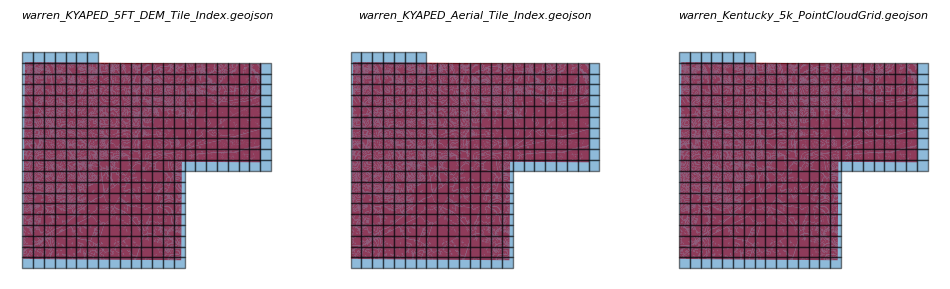

In [4]:
###############################################
# verify coverage of index tiles and datasets
###############################################

# shapefile path of warren county map dataset
shapefile_path = r'../data/warren/geo_warren.shp'

# get list of index geojsons for warren county
index_paths = glob.glob(r'../data/warren/*.geojson')

# read shapefile as geodataframe
gdf = gpd.read_file(shapefile_path)

# create subplots
fig, ax = plt.subplots(ncols=3, figsize=(12,4))

# iterate through list of geojson index paths
for idx, path in enumerate(index_paths):

    # read index geojson as geodataframe
    gdf_index = gpd.read_file(path)

    # plot...
    gdf.plot(ax=ax[idx], color='red')
    gdf_index.plot(ax=ax[idx], edgecolor='k', alpha=0.5)
    ax[idx].set_title(os.path.basename(path), style='italic', fontsize=8)
    ax[idx].set_axis_off()
    
plt.show()

## *Hardin County*

# DEM

* The Kentucky statewide digital elevation model (DEM) is derived from airborne lidar collected since 2010. The data collection prograrm has been divided into phases based on time and resolution, with Phase 1 resulting in a 5 foot resolution DEM, and a 2 foot resolution DEM for Phase 2. The data is publicly available as downloads of small tiles in either .img (with associated metadata files) or .tif (GeoTIFF).

* The code below...
    1. The tile index grids are used to download the relevant individual .tif files for the 5 foot DEM (Phase 1) in the Warren and Hardin County datasets.
    2. Individual DEM tiles are then mosaiced into a single DEM for each area and saved as a new GeoTIFF.
    3. The single DEMs for each area are finally clipped to the project area extents of Warren and Hardin Counties. 

## *Warren County*

In [ ]:
###############################################
# download DEM tiles (.tif) for Warren County
###############################################

# path to geojson dem tile index
index_path = r'../data/warren/warren_KYAPED_5FT_DEM_Tile_Index.geojson'

# field containing unique tile id for file naming
id_field = 'TileName'

# field containing geotiff download url
url_field = 'Phase1_AWS_url'

# output directory to save downloaded tiles
output_dir = r'../data/warren/dem_tiles'

# call custom function to download tiles
download_data_tiles(index_path, id_field, url_field, output_dir)

In [ ]:
#######################################
# merge dem tiles into single geotiff
#######################################

# directory containing dem tiles
dem_dir = r'../data/warren/dem_tiles'

# output path for single mosaiced dem
output_dem_path = r'../data/warren/dem.tif'

# custom function to mosaic dem image tiles and save as new single dem image
mosaic_image_tiles(dem_dir, output_dem_path)

In [ ]:
#########################################
# clip dem to warren county area extent
#########################################

input_dem_path = r'../data/warren/dem.tif'

boundary_path = r'../data/warren/geo_warren.shp'

# output_dem_path = r'../data/warren/dem_clipped.tif'

# clip_image_to_boundary(input_dem_path, boundary_path, output_dem_path)

In [ ]:
gdf = gpd.read_file(boundary_path)

In [ ]:
holes = []

for idx, row in gdf.iterrows():

    polygon = row['geometry']

    if len(polygon.interiors) > 0:

        is_contained = False

        for other_idx, other_row in gdf.iterrows():

            other_polygon = other_row['geometry']

            if idx != other_idx:

                if other_polygon.contains(polygon):

                    is_contained = True
                    break

        if not is_contained:
            holes.append(idx)

len(holes)

In [ ]:
holes[:10]

In [ ]:
poi = 22

fig, ax = plt.subplots()

bounds = gdf.loc[poi, 'geometry'].bounds

gdf.plot(ax=ax, color='gray')
gdf.loc[[poi]].plot(ax=ax)

ax.set_xlim([bounds[0], bounds[2]])
ax.set_ylim([bounds[1], bounds[3]])

plt.show()

1
254
None
EPSG:3089
(0.5, 0.5)


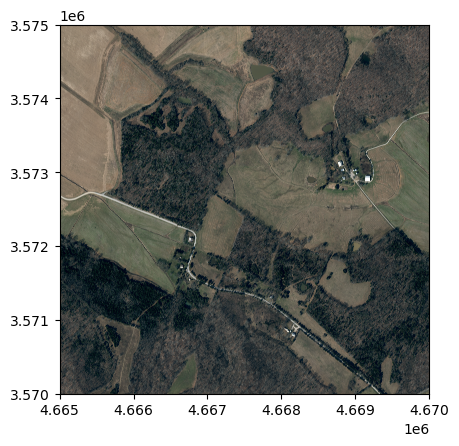

In [9]:
input = r'/Users/matthew/GitHub/cs612/data/warren/aerial_tiles/N158E178_2021.tif'

with rasterio.open(input) as t:
    data = t.read(1, masked=True)
    print(np.min(data))
    print(np.max(data))
    print(t.nodata)
    print(t.meta['crs'])
    print(t.res)
    show(t)

## *Hardin County*

# Aerial Imagery

* Aerial imagery has been collected simultaneously with lidar through the KyFromAbove program with resolutions between 1 foot to 3 inches, and complete statewide coverage of 6 inches. Imagery was collected for true color imagery with three bands (RGB), but near infrared has been captured as a fourth band in some areas; however, only true color imagery is available for download. Aerial imagery is available for download as individual tiles in ERDAS Imagine .img or .jpg formats.

* The code below...
    1. The tile index grids are used to download individual aerial imagery tiles.
    2. Individual tiles are mosaiced together and then saved as a single GeoTIFF image.
    3. The single aerial imagery files are then clipped to the boundaries of the Warren and Hardin Counties datasets.

## *Warren County*

In [ ]:
#########################################################
# download aerial imagery tiles (.img) for Warren County
#########################################################

# path to geojson aerial imagery tile index
index_path = r'../data/warren/warren_KYAPED_Aerial_Tile_Index.geojson'

# field containing unique tile id for file naming
id_field = 'TileName'

# field containing geotiff download url (only available column for image downloads, 6 inch resolution)
url_field = 'Boxzip2021'

# output directory to save downloaded tiles
output_dir = r'../data/warren/aerial_tiles'

# call custom function to download tiles
download_data_tiles(index_path, id_field, url_field, output_dir)

In [ ]:
##################################################
# merge aerial imagery tiles into single geotiff
##################################################

# directory containing aerial imagery tiles
aerial_dir = r'../data/warren/aerial_tiles'

# output path for single mosaiced aerial image
output_aerial_path = r'../data/warren/aerial.tif'

# custom function to mosaic aerial image tiles and save as new single image
mosaic_image_tiles(aerial_dir, output_aerial_path)